In [1]:
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

In [2]:
import scienceplots
plt.style.use(['default'])
plt.style.use(['science', 'no-latex'])

In [3]:
def generate_hypothesis(n: int = 100, dim: int = 2):

    '''
    Generate points, S, and labels, y, for a hypothesis function, h_{S,v}, 
    given the size, |S|, of the set, S, and the dimensionality of the data.

    Parameters
    ----------
    n: int
        size of the set, S.
    dim: int
        dimensionality of the dataset.
    
    Returns
    -------
    S: np.ndarray
        Numpy array of shape (n, dim) of points used to sample from the hypothesis.
    y: np.ndarray
        Numpy array of shape (n,) of labels (0 or 1) for the points in S. 
    '''
    
    # Sample n random elements from R^{dim}.
    S = np.random.uniform(size=(n, dim))
    # Sample n random labels from {0, 1}.
    y = np.random.choice((0, 1), size=100, replace=True)

    return S, y

def pairwise_distances(X1, X2):

    '''
    Calculate pairwise distances between points in two input arrays.

    Parameters
    ----------
    X1: np.ndarray
        Numpy array of shape (n, dim) consisting of the first set of points.
    X2: np.ndarray
        Numpy array of shape (m, dim) consisting of the second set of points.
    
    Returns
    -------
    distances: np.ndarray
        Numpy array of shape (n, m) of pairwise distances between the points in 
        the two sets. distances[i, j] gives the distance between X1[i] and X2[j].
    '''

    # Ensure that the arrays are 2-dimensional and the size of the dim axis matches.
    assert len(X1.shape) == len(X2.shape) == 2 and X1.shape[1] == X2.shape[1]
    # Calculate pairwise distances by brodcasting X1 to shape (n, 1, dim) and X2 to (1, m, dim).
    distances = np.linalg.norm(np.expand_dims(X1, 1) - np.expand_dims(X2, 0), ord=2, axis=-1)

    return distances

In [4]:
class KNN:

    '''
    KNN model.

    Attributes
    ----------
    k: int
        Number of nearest neighbors to check during inference.
    train_x: np.ndarray
        Numpy array of shape (n, dim) consisting of the n training points.
    train_y: np.ndarray
        Numpy array of shape (n,) consisting of the labels (0 or 1) for the 
        points in train_x.
    
    Methods
    -------
    distance(test_x):
        Calculate the pairwise distances between the points in the training
        set and the points in the test set.
    predict(test_x):
        Predict the labels for the points in the testing set using hard-voting
        with the labels of the k nearest points in the training set.
    '''

    def __init__(self, k: int, train_x: np.ndarray, train_y: np.ndarray):

        '''
        Parameters
        ----------
        k: int
            Number of nearest neighbors to check during inference.
        train_x: np.ndarray
            Numpy array of shape (n, dim) consisting of the n training points.
        train_y: np.ndarray
            Numpy array of shape (n,) consisting of the labels (0 or 1) for the 
            points in train_x.
        '''

        self.k = k
        self.train_x = train_x
        self.train_y = train_y

    def distance(self, test_x: np.ndarray):

        '''
        Calculate the pairwise distances between the points in the training set 
        and the points in the test set.

        Parameters
        ----------
        test_x: np.ndarray
            Numpy array of shape (m, dim) consisting of the test points.
        
        Returns
        -------
        distances: np.ndarray
            Numpy array of shape (m, n) of pairwise distances between the points 
            in test_x and train_x. 
            distances[i, j] gives the distance between test_x[i] and train_x[j].
        '''

        # Calculate pairwise distances between points in test_x and train_x.
        distances = pairwise_distances(test_x, self.train_x)

        return distances

    def predict(self, test_x: np.ndarray):

        '''
        Predict the labels for the points in the testing set using hard-voting
        with the labels of the k nearest points in the training set.

        Parameters
        ----------
        test_x: np.ndarray
            Numpy array of shape (m, dim) consisting of the test points.
        
        Returns
        -------
        predictions: np.ndarray
            Numpy array of shape (m,) of predicted labels for the points in test_x.
        '''

        # If test_x is a 1D vector, reshape it as a row matrix of shape (1, dim). 
        if len(test_x.shape) == 1:
            test_x = test_x.reshape(-1, self.train_x.shape[1])
        
        # Calculate pairwise distances between points in test_x and train_x.
        pairwise_distances = self.distance(test_x)
        # For each point in test_x, find the indices of the k nearest points in train_x.
        nearest_indices = np.argpartition(pairwise_distances, self.k)[:, :self.k]
        # For each point in test_x, find the labels of the k nearest points in train_x.
        nearest_labels = self.train_y[nearest_indices]
        # Predict the label for each point in test_x as the mode of the labels of the k 
        # nearest points in train_x.
        predictions = mode(nearest_labels.T, keepdims=False).mode

        return predictions

In [5]:
class Hypothesis:

    '''
    Hypothesis function, h_{S,v}, used for generating samples and their labels.

    Attributes
    ----------
    n: int
        Number of points in the set, S, used for sampling points from h_{S,v}.
    dim: int
        Dimensionality of the domain of h_{S,v}, i.e., dimensionality of the points in S.
    v: int
        Number of nearest neighbors to consider when sampling labels.
    
    Methods
    -------
    sample(n, threshold):
        Sample n points from h_{S,v}. Labels are sampled from a KNN with k=v with 
        probability p, and randomly from {0, 1} with probability 1-p.
    '''

    def __init__(self, n: int = 100, dim: int = 2, v: int = 3):
    
        # Sample S randomly from [0, 1]^{dim} and y from {0, 1}.
        self.S, self.y = generate_hypothesis(n=n, dim=dim)
        # Set up a KNN model (used when sample points from h_{S,v}). 
        self.knn = KNN(k=v, train_x=self.S, train_y=self.y)
        # Dimensionality of the points in S.
        self.dim = dim

    def sample(self, n: int = 4000, p: float = 0.8):

        '''
        Sample n points from h_{S,v}. Labels are sampled from a KNN with k=v with 
        probability p, and randomly from {0, 1} with probability 1-p.

        Parameters
        ----------
        n: int
            Number of points to sample.
        p: float
            Probability of accepting the KNN prediction as label. Otherwise, a 
            random label is assigned.

        Returns
        -------
        xs: np.ndarray
            Numpy array of shape (n, dim) of points sampled uniformly from [0, 1]^{dim}.
        labels: np.ndarray
            Numpy array of shape (n,) consisting of labels, for points in xs, sampled from h_{S,v}.  
        '''

        # Sample n points randomly from [0, 1]^{dim}.
        xs = np.random.uniform(size=(n, self.dim))
        # Generate predictions from a KNN model with training points, S, and k=v.
        preds = self.knn.predict(test_x=xs)
        # Generate n random labels {0, 1}. 
        random_labels = np.random.choice((0, 1), size=n)
        # With probability p, use the KNN predictions for labels. Otherwise, use a random label. 
        labels = np.where(np.random.uniform(size=n) < p, preds, random_labels)

        return xs, labels

In [6]:
# Define the dimension of the dataset.
dim = 2
# Generate a random hypothesis function, h_{S,v}.
h = Hypothesis(n=100, v=3, dim=dim)

# Generate a 300x300 grid, G, of points in [0, 1].
linspace = np.linspace(0, 1, num=300).reshape(-1, 1)
axes = np.meshgrid(*[linspace for _ in range(dim)])
G = np.concatenate([axis.reshape(-1, 1) for axis in axes], axis=1)

# Predict the labels for the points in the grid using the hypothesis, h_{S,v}.
preds = h.knn.predict(test_x=G)

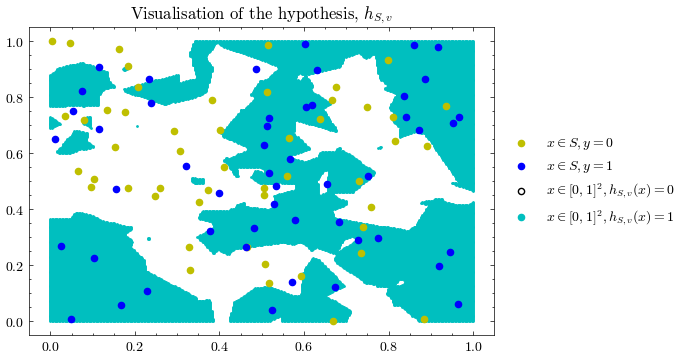

In [7]:
# Plot the points, S, and the points in the grid, using different colors for points with labels 0 those with label 1.

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.scatter(G[(preds==0).ravel(), 0], G[(preds==0).ravel(), 1], color='w', s=1, label=r'$x\in [0, 1]^2, h_{S,v}(x)=0$')
axs.scatter(G[(preds==1).ravel(), 0], G[(preds==1).ravel(), 1], color='c', s=1, label=r'$x\in [0, 1]^2, h_{S,v}(x)=1$')
axs.scatter(h.S[(h.y==0).ravel(), 0], h.S[(h.y==0).ravel(), 1], color='y', s=20, label=r'$x\in S, y=0$')
axs.scatter(h.S[(h.y==1).ravel(), 0], h.S[(h.y==1).ravel(), 1], color='b', s=20, label=r'$x\in S, y=1$')
axs.set_title(r'Visualisation of the hypothesis, $h_{S,v}$', fontdict={'font': 'serif', 'size': 12})

# Edit the legend to reorder the entries and add a border for the white points.
order = [2, 3, 0, 1]
handles, labels = fig.gca().get_legend_handles_labels()
legend = axs.legend(*zip(*[(handles[idx], labels[idx]) for idx in order]), loc='center left', bbox_to_anchor=(1, 0.5)) 
for i in range(4):
    legend.legend_handles[i]._sizes = [20]
axs.legend_.legend_handles[2].set_edgecolor('black')

plt.savefig('assets/q6_visualisation.png')
plt.show()

In [8]:
# Define the number of runs, values of k to loop over, and the number of training points.
n_runs, ks, m = 100, range(1, 50), 4000
# Define an array to store the generalization errors from each run with each value of k.
gen_errors = np.zeros(shape=(len(ks), n_runs))

for run in tqdm(range(n_runs)):

    # Generate a random hypothesis, h_{S,v}, in each run.
    h = Hypothesis(n=100, v=3, dim=dim)
    # Generate a training set of 4,000 points and their labels using h_{S,v}.
    train_x, train_y = h.sample(n=m, p=0.8)
    # Generate a testing set of 1,000 points and their labels using h_{S,v}.
    test_x, test_y = h.sample(n=1000, p=0.8)
    # Set up a KNN classifier.
    knn = KNN(k=None, train_x=train_x, train_y=train_y)
    # Pre-compute pairwise distances between the points in train_x and those in test_x.
    precomputed_distances = knn.distance(test_x=test_x)
    
    # Compute the indices of the training points closest to a each test point. indices are unsorted right now.
    nearest_indices_unsorted = np.argpartition(precomputed_distances, max(ks))[:, :max(ks)]
    # Retrieve the distances these training points are from the corresponding test points.
    nearest_distances_unsorted = precomputed_distances[np.tile(np.arange(1000), (max(ks), 1)).T, nearest_indices_unsorted]
    # Argsort the distances of the subset of training points closest to the corresponding test points.
    nearest_indices_subset_sorted = np.argsort(nearest_distances_unsorted, axis=1)
    # Get the sorted order of indices of training points closest to the corresponding test points.
    nearest_indices_sorted = nearest_indices_unsorted[np.tile(np.arange(1000), (max(ks), 1)).T, nearest_indices_subset_sorted]
    # Run time = O(m+klogk), where m is the number of test points and k = max(ks).*
    
    for k in ks:
        # Find the labels of the k closest training points.
        nearest_labels = train_y[nearest_indices_sorted[:, :k]]
        # Predict the label for each test point as the mode of the labels of the k nearest training points.
        predictions = mode(nearest_labels.T, keepdims=False).mode
        # Calculate the generalization error as the misclassification rate.
        gen_errors[k-1, run] = np.mean(predictions != test_y)

_ = '''
    *The routine is equivalent to the following operation:

    # Find the indices of the max(ks) training points closest to each point in test_x. 
    nearest_indices = np.argsort(precomputed_distances, axis=1)[:, :max(ks)]

    Run time = O(mlogm), where m is the number of test points.
'''

  0%|          | 0/100 [00:00<?, ?it/s]

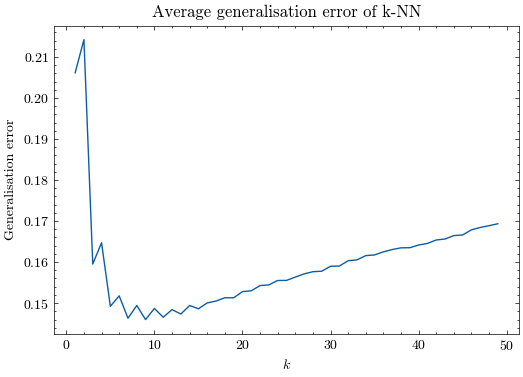

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.plot(ks, gen_errors.mean(axis=1))
axs.set_title('Average generalisation error of k-NN')
axs.set_xlabel(r'$k$')
axs.set_ylabel('Generalisation error')

plt.savefig('assets/q7_gen-error-vs-k.png')
plt.show()

From the figure above, it is clear that the generalization error rapidly drops with increasing value of $k$ up to a point, after which the error starts to increase again. This is because a small $k$ leads to a complex model that can fit to the noise in the training data, resulting in overfitting. Conversely, a large $k$ can cause the model to oversimplify and not capture the underlying patterns in the data, leading to underfitting. The optimal value of $k$ strikes a balance, minimizing the generalization error by ensuring the model is neither too complex nor too simplistic. 

We note that for $m=4000$, the optimal value of $k$ is around $10$. Lowering $k$ sharply increases the generalization error, as does increasing $k$, albeit at a slower rate.

In [10]:
# Define the values of m (the size of the training set) to loop over, the number of runs, and the values of k to loop over.
ms, n_runs, ks = [100] + list(range(500, 4001, 500)), 100, range(1, 50)
# Define an array to store the "optimal k" from each run with each value of m.
optimal_ks = np.zeros(shape=(len(ms), n_runs))

for run in tqdm(range(n_runs)):

    # Generate a random hypothesis, h_{S,v}, in each run.
    h = Hypothesis(n=100, v=3, dim=dim)
    # Generate a training set of 4,000 points and their labels using h_{S,v}.
    train_x, train_y = h.sample(n=m, p=0.8)
    # Generate a testing set of 1,000 points and their labels using h_{S,v}.
    test_x, test_y = h.sample(n=1000, p=0.8)
    # Set up a KNN classifier.
    knn = KNN(k=None, train_x=train_x, train_y=train_y)
    # Pre-compute pairwise distances between the points in train_x and those in test_x.
    precomputed_distances = knn.distance(test_x=test_x)
   
    for i, m in enumerate(ms):
        
        # Sample a subset of indices to construct a training set of size m.
        subset_indices = np.random.choice(max(ms), size=m, replace=False)
        # Extract the precomputed_distances corresponding to this subset of training points.
        precomputed_distances_subset = precomputed_distances[:, subset_indices]
        # Extract the labels for this subset of training points.
        train_y_subset = train_y[subset_indices]
        # For all test points, find the indices of the nearest training points in the subset.
        nearest_indices = np.argsort(precomputed_distances_subset, axis=1)[:, :max(ks)]
        
        generalization_errors = list()
        for k in ks:
            # Find the labels of the k closest training points.
            nearest_labels = train_y_subset[nearest_indices[:, :k]]
            # Predict the label for each test point as the mode of the labels of the k nearest training points.
            predictions = mode(nearest_labels.T, keepdims=False).mode
            # Calculate the generalization error as the misclassification rate and append it with k to the list 
            # of generalization errors for a given run and a given m.
            generalization_errors.append((np.mean(predictions!=test_y), k))

        # Set the value of k with the minimum generalization error for a given run and a given m.
        min_generalization_error, best_k = min(generalization_errors)
        optimal_ks[i, run] = best_k

  0%|          | 0/100 [00:00<?, ?it/s]

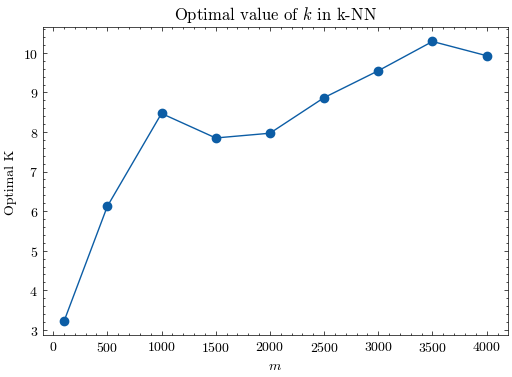

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.plot(ms, optimal_ks.mean(axis=1), marker='o')
axs.set_title(r'Optimal value of $k$ in k-NN')
axs.set_xlabel(r'$m$')
axs.set_ylabel('Optimal K')

plt.savefig('assets/q8_optimal-k.png')
plt.show()

From the plot above, we conclude that the optimal value of $k$ increases with $m$. This can be understood as follows:
- Low $m$: The training points are distributed sparsely in the input space, $[0, 1]^2$. Using a large $k$ will lead to inclusion of noisy labels (from points which are far from the test point) for making predictions, leading to underfitting. Since each point carries information about the local structure of the data, a small $k$ can allow the model to adapt closely to the limited available data, capturing detailed patterns that exist within it.
- Large $m$: The density of the sampling space increases, so even higher values of $k$ will still refer to *near* neighbors, reducing the noise in the prediction. A large $k$ smooths over peculiarities, leading to more robust predictions, which results in better generalization.